## Importing Essential Libraries

In [1]:
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import os
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

## Importing Data and Preprocessing

In [2]:
data_path = "/kaggle/input/datasettt/Quark Gluon Data Set.hdf5"

with h5py.File(data_path, 'r') as f:
    X_jets = f['X_jets'][0:10000]        

In [3]:
#resizing images from (125, 125, 3) to (128, 128, 3)
X_jets_resized = np.zeros((X_jets.shape[0], 128, 128, 3))
for i in range(X_jets.shape[0]):
    img_tensor = torch.from_numpy(X_jets[i]).permute(2, 0, 1).float()
    img_resized = F.resize(img_tensor, [128, 128])
    X_jets_resized[i] = img_resized.permute(1, 2, 0).numpy()

X_jets = X_jets_resized
del X_jets_resized

#normalize the input images using min-max scaling
X_jets = (X_jets - X_jets.min()) / (X_jets.max() - X_jets.min())

## Data Visualization

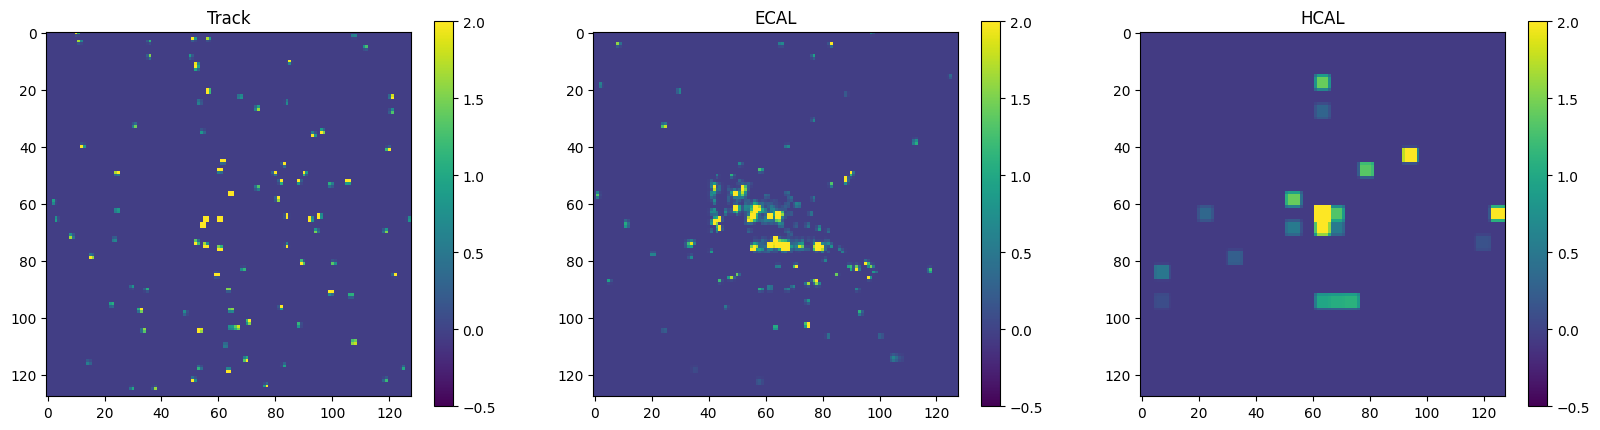

In [4]:
mean_track = np.mean(X_jets[:,:,:,0])
std_track = np.std(X_jets[:,:,:,0])
normalized_track = (X_jets[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(X_jets[:,:,:,1])
std_ecal = np.std(X_jets[:,:,:,1])
normalized_ecal = (X_jets[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(X_jets[:,:,:,2])
std_hcal = np.std(X_jets[:,:,:,2])
normalized_hcal = (X_jets[:,:,:,2] - mean_hcal) / std_hcal

combined = normalized_track + normalized_ecal + normalized_hcal
combined = np.expand_dims(combined, axis=-1)

fig, axs = plt.subplots(1, 3, figsize=(20, 20))

im1 = axs[0].imshow(normalized_track[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[0].set_title('Track')

im2 = axs[1].imshow(normalized_ecal[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[1].set_title('ECAL')

im3 = axs[2].imshow(normalized_hcal[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[2].set_title('HCAL')

fig.colorbar(im1, ax=axs[0], shrink=0.25)
fig.colorbar(im2, ax=axs[1], shrink=0.25)
fig.colorbar(im3, ax=axs[2], shrink=0.25)

plt.show()

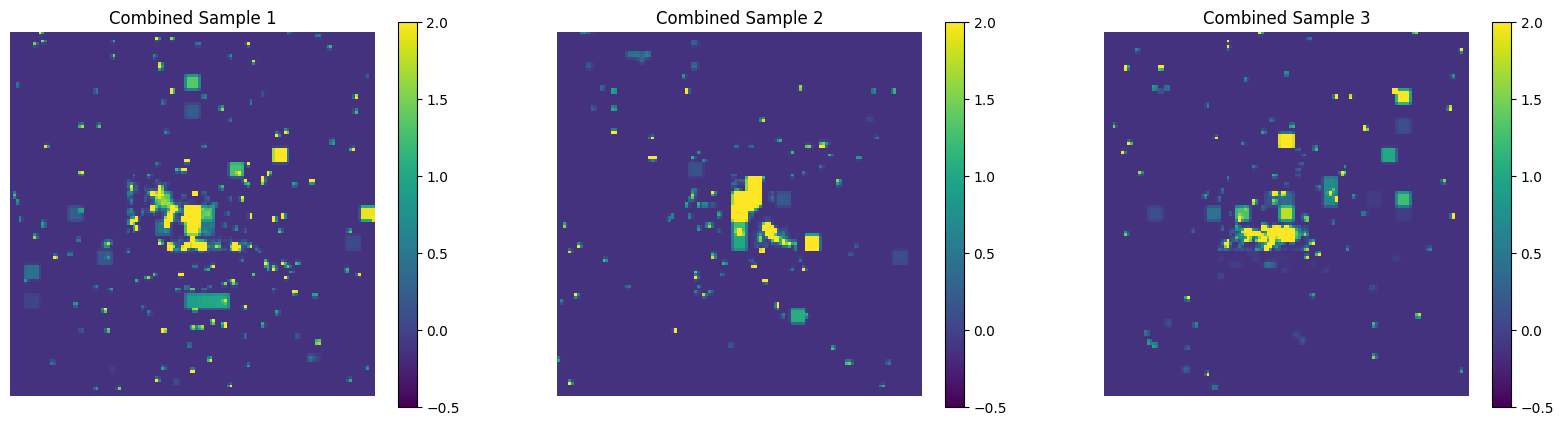

In [5]:
#number of images to display
num_images = 3

fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 20))
for i in range(3):
    temp = axes[i].imshow(combined[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title('Combined Sample {}'.format(i+1))
    fig.colorbar(temp, ax=axes[i], shrink=0.25)

del mean_track, std_track, normalized_track
del mean_ecal, std_ecal, normalized_ecal
del mean_hcal, std_hcal, normalized_hcal
del combined

## Building and Training the Model

In [6]:
X_jets_tensor = torch.from_numpy(X_jets).permute(0, 3, 1, 2).float() 

#create dataset and split into train and validation
dataset = TensorDataset(X_jets_tensor, X_jets_tensor)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], 
                                          generator=torch.Generator().manual_seed(42))

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim=1024):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.flatten_size = 64 * 32 * 32
        
        self.fc = nn.Linear(self.flatten_size, 1024)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, 16 * 16 * 64)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = torch.relu(self.fc(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        x = torch.relu(self.decoder_input(z))
        x = x.view(-1, 64, 16, 16)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

In [9]:
def vae_loss(x, recon_x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    #KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    return BCE + KLD

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
patience = 3
best_val_loss = float('inf')
counter = 0

num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(data, recon_batch, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            val_loss += vae_loss(data, recon_batch, mu, logvar).item()
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    #early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_vae_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Epoch: 1, Train Loss: 1128.8718, Val Loss: 30.0765
Epoch: 2, Train Loss: 566.8860, Val Loss: 34.9691
Epoch: 3, Train Loss: 30.9669, Val Loss: 27.0273
Epoch: 4, Train Loss: 25.7028, Val Loss: 23.6499
Epoch: 5, Train Loss: 22.3736, Val Loss: 20.2099
Epoch: 6, Train Loss: 19.4376, Val Loss: 19.5201
Epoch: 7, Train Loss: 18.6503, Val Loss: 17.1544
Epoch: 8, Train Loss: 14.5555, Val Loss: 13.3720
Epoch: 9, Train Loss: 13.0852, Val Loss: 12.2782
Epoch: 10, Train Loss: 12.0605, Val Loss: 11.4425
Epoch: 11, Train Loss: 10.9978, Val Loss: 10.2468
Epoch: 12, Train Loss: 9.9860, Val Loss: 9.4595
Epoch: 13, Train Loss: 9.4532, Val Loss: 9.0032
Epoch: 14, Train Loss: 8.9256, Val Loss: 8.6645
Epoch: 15, Train Loss: 8.5485, Val Loss: 8.3547
Epoch: 16, Train Loss: 8.3214, Val Loss: 8.1504
Epoch: 17, Train Loss: 8.1749, Val Loss: 8.0017
Epoch: 18, Train Loss: 8.0656, Val Loss: 7.9495
Epoch: 19, Train Loss: 8.0026, Val Loss: 7.8520
Epoch: 20, Train Loss: 7.9346, Val Loss: 7.8442
Epoch: 21, Train Loss: 7

In [13]:
samples = X_jets_tensor[:3].to(device)

model.eval()
with torch.no_grad():
    reconstructed_samples, mu, logvar = model(samples)
    reconstructed_samples = reconstructed_samples.cpu().numpy()
    
reconstructed_samples = np.transpose(reconstructed_samples, (0, 2, 3, 1))

mean_track = np.mean(X_jets[:,:,:,0])
std_track = np.std(X_jets[:,:,:,0])
normalized_track = (X_jets[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(X_jets[:,:,:,1])
std_ecal = np.std(X_jets[:,:,:,1])
normalized_ecal = (X_jets[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(X_jets[:,:,:,2])
std_hcal = np.std(X_jets[:,:,:,2])
normalized_hcal = (X_jets[:,:,:,2] - mean_hcal) / std_hcal

X_jets_combined = normalized_track + normalized_ecal + normalized_hcal
X_jets_combined = np.expand_dims(X_jets_combined, axis=-1) 

mean_track = np.mean(reconstructed_samples[:,:,:,0])
std_track = np.std(reconstructed_samples[:,:,:,0])
normalized_track = (reconstructed_samples[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(reconstructed_samples[:,:,:,1])
std_ecal = np.std(reconstructed_samples[:,:,:,1])
normalized_ecal = (reconstructed_samples[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(reconstructed_samples[:,:,:,2])
std_hcal = np.std(reconstructed_samples[:,:,:,2])
normalized_hcal = (reconstructed_samples[:,:,:,2] - mean_hcal) / std_hcal

reconstructed_combined = normalized_track + normalized_ecal + normalized_hcal
reconstructed_combined = np.expand_dims(reconstructed_combined, axis=-1) 

del mean_track, std_track, normalized_track
del mean_ecal, std_ecal, normalized_ecal
del mean_hcal, std_hcal, normalized_hcal

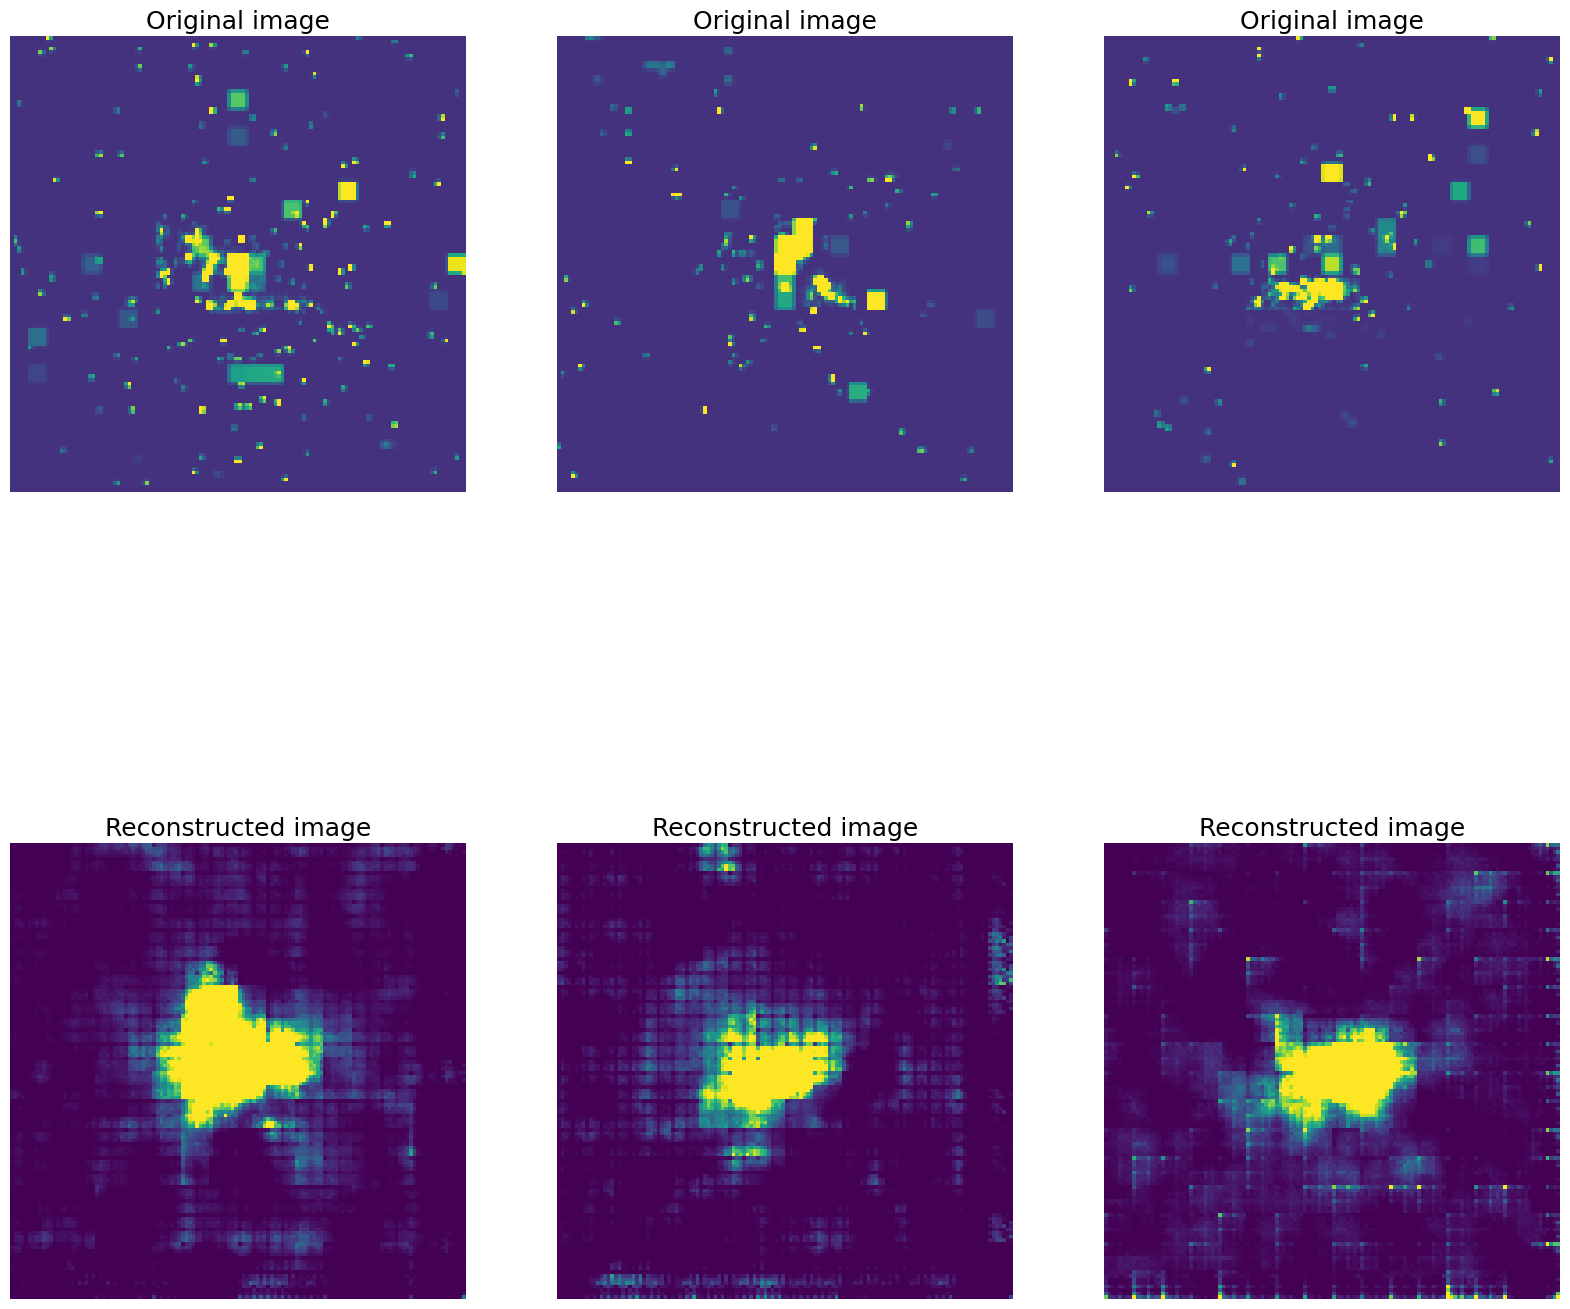

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i in range(3):
    axes[0, i].imshow(X_jets_combined[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original image', fontsize=18)

for i in range(3):
    axes[1, i].imshow(reconstructed_combined[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed image', fontsize=18)

fig.subplots_adjust(hspace=0.1)
plt.show()

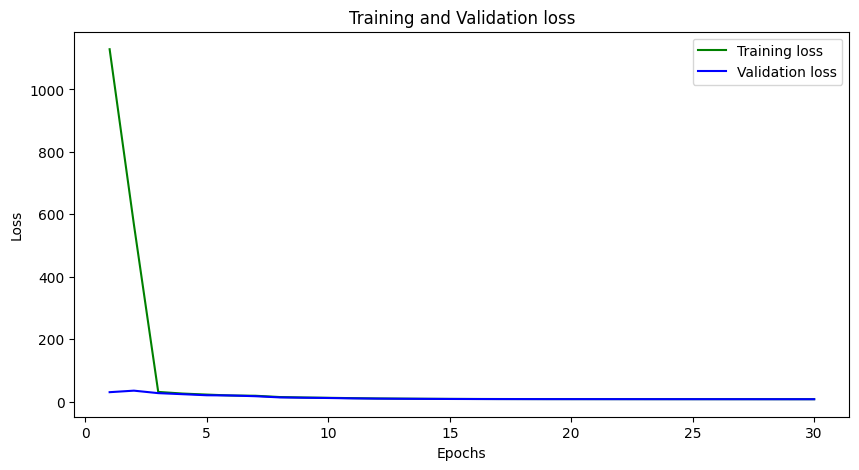

In [14]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Conclusion

+ The Model shows impressive convergence over 30 epochs, with significant improvement (Train Loss: 1128.87→7.64, Val Loss: 30.08→7.53) followed by more gradual refinement, suggesting effective optimization without overfitting.

+ The closely aligned final training and validation losses (7.64 vs 7.53) indicate good generalization.

+ While the continued small improvements in later epochs suggest potential benefit from additional training epochs.